Weight Uncertainty in Neural Networks, Blundell et. al.

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import torch
import time
import math
import experiments.toy_regression as exp

In [3]:
device = torch.device("cpu")

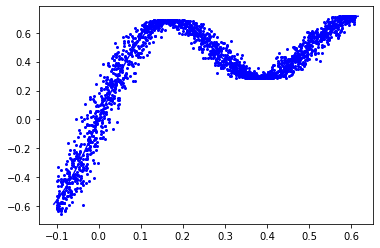

In [4]:
from training import toy
import matplotlib.pyplot as plt

torch.manual_seed(42)

batch_size = 200

trainset = toy.TrigonometricToyDataset(sample_count=2000, noise=0.02, normalize=False, min=-0.1, max=0.61)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

axis = plt.subplot()
trainset.plot_dataset(axis)

In [5]:
from training.bbb import MixturePrior

noise = torch.tensor(0.02).to(device) # 3, 0.02
layers = [
    ("fc", (1, 16)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("relu", ()),
    ("fc", (16, 1))
]
learn_var = False
prior = MixturePrior(0.25, torch.exp(torch.tensor(-0)), torch.exp(torch.tensor(-6)), validate_args=True)

In [66]:
torch.manual_seed(42)
bbb, bbb_loss = exp.bbb(layers, noise, learn_var, 500, trainloader, batch_size, device, global_samples=5, prior=prior, sampling="parameters", kl_rescaling=3)

Generated model: Sequential(
  (0): BBBLinear()
  (1): ReLU()
  (2): BBBLinear()
  (3): ReLU()
  (4): BBBLinear()
  (5): ReLU()
  (6): BBBLinear()
)
1186 trainable parameters
Epoch 0: loss 11.804095268249512
Epoch 10: loss 7.11859130859375
Epoch 20: loss 7.193495273590088
Epoch 30: loss 7.22724723815918
Epoch 40: loss 6.3025126457214355
Epoch 50: loss 5.296508312225342
Epoch 60: loss 5.237279891967773
Epoch 70: loss 5.322229385375977
Epoch 80: loss 5.327308654785156
Epoch 90: loss 5.289897918701172
Epoch 100: loss 5.263067245483398
Epoch 110: loss 5.287436485290527
Epoch 120: loss 5.267828464508057
Epoch 130: loss 5.327718734741211
Epoch 140: loss 5.287048816680908
Epoch 150: loss 5.341365814208984
Epoch 160: loss 5.277017116546631
Epoch 170: loss 5.417438983917236
Epoch 180: loss 5.275601387023926
Epoch 190: loss 5.291471481323242
Epoch 200: loss 5.312414646148682
Epoch 210: loss 5.326888561248779
Epoch 220: loss 5.299136161804199
Epoch 230: loss 5.417881965637207
Epoch 240: loss 5.26

In [ ]:
torch.manual_seed(42)
intel_bbb = exp.intel_bbb(layers, noise, learn_var, 900, trainloader, batch_size)

In [9]:
torch.manual_seed(42)
gp, gp_true_lml = exp.gaussian_process(100, trainset.normalized_xs, trainset.normalized_ys)

Epoch 0: loss 0.772654116153717
Epoch 20: loss -0.09803888201713562
Epoch 40: loss -0.9695585370063782
Epoch 60: loss -1.2259176969528198
Epoch 80: loss -1.2332572937011719


C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1687: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gp

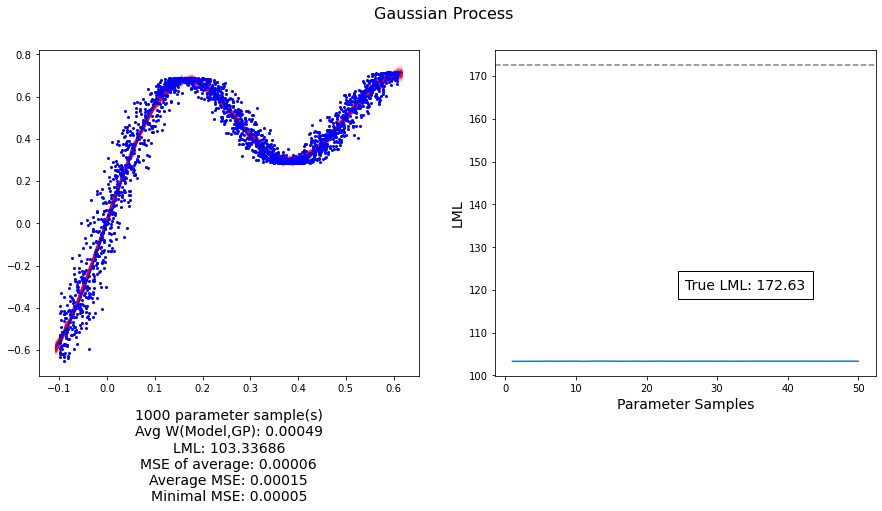

In [11]:
trainset.plot("Gaussian Process", gp, gp, alpha=0.01, samples=1000, plot_lml_trend=(50, 50), gp_lml=gp_true_lml, variance=torch.tensor(0.02))

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1687: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


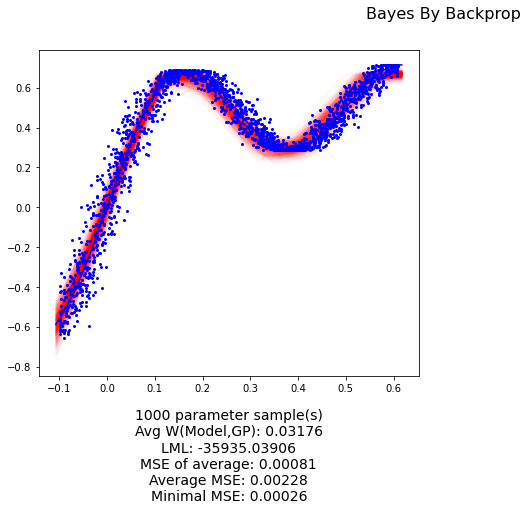

In [67]:
trainset.plot("Bayes By Backprop", bbb, gp, alpha=0.01, samples=1000)

In [8]:
from training.bbb_blundell import BayesianNetwork
torch.manual_seed(0)

def train(net, optimizer, loader):
    #net.train()
    total_loss = torch.tensor(0, dtype=torch.float)

    for (data, target) in loader:
        net.zero_grad()
        x = data.reshape((-1, 1))
        y = target.reshape((-1,1))
        loss = net.BBB_loss(x, y, torch.tensor(0.02).repeat(batch_size))
        total_loss += loss
        loss.backward()
        optimizer.step()
    print(f"Loss: {total_loss / (len(loader) * batch_size)}")

net = BayesianNetwork(inputSize = 1,\
                    CLASSES = 1, \
                    layers=np.array([16,16,16]), \
                    activations = np.array(['relu','relu','relu','none']), \
                    SAMPLES = 5, \
                    BATCH_SIZE = batch_size,\
                    NUM_BATCHES = 2000 / batch_size,\
                    hasScalarMixturePrior = True,\
                    PI = 0.25,\
                    SIGMA_1 = torch.exp(torch.tensor(-0)),\
                    SIGMA_2 = torch.exp(torch.tensor(-6)),\
                    GOOGLE_INIT= False)

optimizer = torch.optim.SGD(net.parameters(),lr=1e-3,momentum=0.95)

for epoch in range(500):
    if (epoch)%10 == 0:
        print('Epoch: ', epoch)
    train(net, optimizer,trainloader)

Epoch:  0
Loss: 0.797740638256073
Loss: 0.7717329263687134
Loss: 0.7726973295211792
Loss: 0.7856060862541199
Loss: 0.7835634350776672
Loss: 0.7669408321380615
Loss: 0.7515166997909546
Loss: 0.7797570824623108
Loss: 0.7853720784187317
Loss: 0.7382562756538391
Epoch:  10
Loss: 0.7513082027435303
Loss: 0.7678984999656677
Loss: 0.7572768330574036
Loss: 0.7585456967353821
Loss: 0.761654257774353
Loss: 0.7418919205665588
Loss: 0.738456130027771
Loss: 0.7324714064598083
Loss: 0.7322638034820557
Loss: 0.7379946708679199
Epoch:  20
Loss: 0.7369654774665833
Loss: 0.7317407727241516
Loss: 0.7269067764282227
Loss: 0.7264654636383057
Loss: 0.7227648496627808
Loss: 0.7241185307502747
Loss: 0.7238202095031738
Loss: 0.7254993915557861
Loss: 0.7215765714645386
Loss: 0.7197995185852051
Epoch:  30
Loss: 0.7185827493667603
Loss: 0.7169077396392822
Loss: 0.7190045118331909
Loss: 0.7160246968269348
Loss: 0.7197751402854919
Loss: 0.71791672706604
Loss: 0.7163562774658203
Loss: 0.7139715552330017
Loss: 0.7163

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1687: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


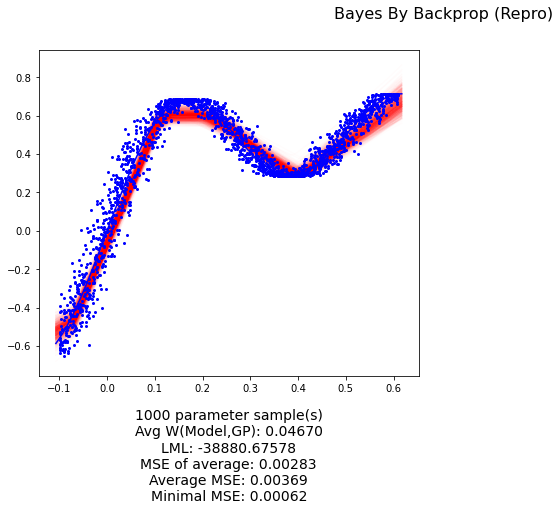

In [11]:
def eval_blundell(input, samples):
    net.eval()
    return [(net(input), torch.tensor(0.02)) for _ in range(samples)]

trainset.plot("Bayes By Backprop (Repro)", eval_blundell, gp, alpha=0.01, samples=1000)

In [21]:
from training.util import gauss_logprob

gauss_logprob(torch.tensor(0), torch.tensor(0.02), torch.tensor(100))

tensor(-249998.9688)